# Fall Detection — PANTS POCKET Mode
**MPU6050 placement: Pants pocket (hip/thigh level)**

---
## Dataset: FallAllD (Waist device — closest proxy for hip)
| Item | Detail |
|------|--------|
| **File** | `data/FallAllD/FallAllD_40SamplesPerSec_ActivityIdsFiltered.pkl` |
| **Device** | `Waist` (FallAllD has no dedicated hip node) |
| **Features** | 26 = 23 base + 3 gait-aware (step_freq, gait_regularity, vertical_symmetry) |
| **Window** | 80 samples = 2 s @ 40 Hz |

**Why gait-aware features?** Hip-level sensors see large periodic leg-swing (~2 Hz) that can mimic freefall. Extra features help distinguish walking from falling.

In [1]:
import os, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from autogluon.tabular import TabularPredictor
warnings.filterwarnings('ignore')

PLACEMENT    = 'PANTS'
PKL_FILE     = 'data/FallAllD/FallAllD_40SamplesPerSec_ActivityIdsFiltered.pkl'
DEVICE       = 'Waist'
SAMPLE_RATE  = 40
WINDOW_SIZE  = 80
STEP_SIZE    = 40
RANDOM_STATE = 42
FALL_START   = 101
os.makedirs('models', exist_ok=True)
print(f'Config: {PLACEMENT}, {SAMPLE_RATE} Hz, {WINDOW_SIZE/SAMPLE_RATE}s window, 26 features')

Config: PANTS, 40 Hz, 2.0s window, 26 features


/Users/frank/Vscode/Hardware-Project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load FallAllD

In [2]:
with open(PKL_FILE, 'rb') as f:
    all_data = pickle.load(f)

df_waist = all_data[all_data['Device'] == DEVICE].copy()
df_waist['label'] = (df_waist['ActivityID'] >= FALL_START).astype(int)
print(f'Waist rows: {len(df_waist):,} | Falls: {df_waist.label.sum():,} | ADL: {(df_waist.label==0).sum():,}')

Waist rows: 1,706 | Falls: 374 | ADL: 1,332


## 2. Feature Extraction — 26 Features (23 base + 3 gait-aware)

In [3]:
def extract_features_26(window, fs=SAMPLE_RATE):
    ax, ay, az = window[:, 0], window[:, 1], window[:, 2]
    mag   = np.sqrt(ax**2 + ay**2 + az**2)
    mag_c = mag - np.mean(mag)
    freqs = fftfreq(len(mag), 1/fs)
    fmag  = np.abs(fft(mag))[:len(mag)//2]
    pf    = freqs[:len(mag)//2]
    jerk  = np.diff(mag) * fs
    # base 23
    f  = [float(np.mean(ax)), float(np.mean(ay)), float(np.mean(az))]
    f += [float(np.std(ax)),  float(np.std(ay)),  float(np.std(az))]
    f += [float(np.min(mag)), float(np.max(mag)), float(np.ptp(mag))]
    f += [float(np.sqrt(np.mean(ax**2))), float(np.sqrt(np.mean(ay**2))), float(np.sqrt(np.mean(az**2)))]
    f += [float(stats.skew(mag)), float(stats.kurtosis(mag))]
    f.append(float(np.sum(np.diff(np.sign(mag_c)) != 0)))
    f.append(float(np.sum(np.abs(ax)+np.abs(ay)+np.abs(az)) / len(ax)))
    f.append(float(pf[np.argmax(fmag)]) if len(fmag) > 0 else 0.0)
    f.append(float(np.sum(fmag**2)))
    f.append(float(np.corrcoef(ax, ay)[0,1]) if np.std(ax)>0 and np.std(ay)>0 else 0.0)
    f.append(float(np.corrcoef(ay, az)[0,1]) if np.std(ay)>0 and np.std(az)>0 else 0.0)
    f.append(float(np.corrcoef(ax, az)[0,1]) if np.std(ax)>0 and np.std(az)>0 else 0.0)
    f.append(float(np.max(np.abs(jerk))) if len(jerk)>0 else 0.0)
    f.append(float(np.var(mag)))
    # gait-aware extras
    gm = (pf >= 0.5) & (pf <= 3.0)
    sf = float(pf[gm][np.argmax(fmag[gm])]) if (gm.any() and len(fmag)==len(pf)) else 0.0
    f.append(sf)
    ac = np.correlate(mag_c, mag_c, mode='full')[len(mag_c)-1:]
    ac = ac / (ac[0] + 1e-9)
    lmin, lmax = int(0.4*fs), int(1.2*fs)
    gr = float(ac[lmin:lmax].max()) if lmax < len(ac) else 0.0
    f.append(gr)
    f.append(float(np.std(az) / (np.std(ax) + np.std(ay) + 1e-9)))
    assert len(f) == 26
    return np.array(f, dtype=np.float32)

FEATURE_NAMES = [
    'mean_ax','mean_ay','mean_az','std_ax','std_ay','std_az',
    'min_mag','max_mag','range_mag','rms_ax','rms_ay','rms_az',
    'skewness','kurtosis','zero_cross','SMA',
    'dom_freq','spectral_energy','corr_xy','corr_yz','corr_xz',
    'max_jerk','acc_variance',
    'step_freq','gait_regularity','vertical_symmetry',
]
print(f'{len(FEATURE_NAMES)} features')

26 features


In [4]:
def build_feature_df(df, win=WINDOW_SIZE, step=STEP_SIZE):
    rows = []
    for _, row in df.iterrows():
        acc   = row['Acc'].astype(np.float32)
        label = int(row['label'])
        for s in range(0, len(acc) - win, step):
            rows.append(np.append(extract_features_26(acc[s:s+win]), label))
    result = pd.DataFrame(rows, columns=FEATURE_NAMES + ['label'])
    result['label'] = result['label'].astype(int)
    return result

print('Extracting features...')
feat_df = build_feature_df(df_waist)
print(f'Windows: {len(feat_df):,} | Falls: {feat_df.label.sum():,} ({feat_df.label.mean()*100:.1f}%) | ADL: {(feat_df.label==0).sum():,}')
feat_df.head(3)

Extracting features...
Windows: 30,708 | Falls: 6,732 (21.9%) | ADL: 23,976


,mean_ax,mean_ay,mean_az,std_ax,std_ay,std_az,min_mag,max_mag,range_mag,rms_ax,...,spectral_energy,corr_xy,corr_yz,corr_xz,max_jerk,acc_variance,step_freq,gait_regularity,vertical_symmetry,label
0,3853.602051,-1186.545532,-142.021225,318.389160,369.615204,473.537872,3160.937988,5538.012695,2377.074707,3866.732422,...,1.067845e+11,-0.067155,-0.170616,-0.189104,42164.667969,110631.703125,1.5,0.231891,0.688277,0
1,3798.260498,-1272.063477,165.499069,403.373535,370.763245,294.199463,3160.937988,5538.012695,2377.074707,3819.619385,...,1.047713e+11,-0.105342,0.402848,-0.270065,42164.667969,176990.718750,1.0,0.304154,0.380036,0
2,3859.153076,-1274.434326,81.441719,446.252502,388.971985,249.401321,2985.322998,5629.141113,2643.818115,3884.868652,...,1.077231e+11,-0.059396,0.451328,-0.295708,36247.265625,209515.296875,1.5,0.301322,0.298604,0


## 3. Train with AutoGluon

In [5]:
train_df, test_df = train_test_split(
    feat_df, test_size=0.2, random_state=RANDOM_STATE, stratify=feat_df['label'])
print(f'Train: {len(train_df):,}  |  Test: {len(test_df):,}')

predictor = TabularPredictor(
    label='label', eval_metric='f1',
    path=f'models/{PLACEMENT}_autogluon', verbosity=2,
).fit(train_data=train_df, presets='medium_quality', time_limit=300)

Verbosity: 2 (Standard Logging)
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.13.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.0.0: Mon Aug 12 20:54:26 PDT 2024; root:xnu-11215.1.10~2/RELEASE_ARM64_T8112
CPU Count:          8
Pytorch Version:    Can't import torch
CUDA Version:       Can't get cuda version from torch
Memory Avail:       6.22 GB / 24.00 GB (25.9%)
Disk Space Avail:   584.29 GB / 926.35 GB (63.1%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/frank/Vscode/Hardware-Project/ML/models/PANTS_autogluon"
Train Data Rows:    24566
Train Data Columns: 26
Label Column:       label
AutoGluon in

Train: 24,566  |  Test: 6,142


	Fitting with cpus=8, gpus=0, mem=0.0/6.1 GB
		`import lightgbm` failed. A quick tip is to install via `pip install autogluon.tabular[lightgbm]==1.5.0`.
Fitting model: LightGBM ... Training model for up to 299.84s of the 299.84s of remaining time.
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
	Fitting with cpus=8, gpus=0, mem=0.0/6.1 GB
		`import lightgbm` failed. A quick tip is to install via `pip install autogluon.tabular[lightgbm]==1.5.0`.
Fitting model: RandomForestGini ... Training model for up to 299.78s of the 299.78s of remaining time.
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
	Fitting with cpus=8, gpus=0, mem=0.1/6.1 GB
	0.7914	 = Validation score   (f1)
	4.69s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ... Training model for up to

## 4. Evaluation

=== PANTS — Test Results ===
              precision    recall  f1-score   support

         ADL       0.95      0.97      0.96      4796
        FALL       0.87      0.81      0.84      1346

    accuracy                           0.93      6142
   macro avg       0.91      0.89      0.90      6142
weighted avg       0.93      0.93      0.93      6142

AUC-ROC: 0.9707

=== Leaderboard ===
              model  score_test  score_val
     ExtraTreesGini    0.845433   0.761062
   RandomForestEntr    0.843198   0.785329
     ExtraTreesEntr    0.836991   0.777409
   RandomForestGini    0.836028   0.791398
WeightedEnsemble_L2    0.836028   0.791398


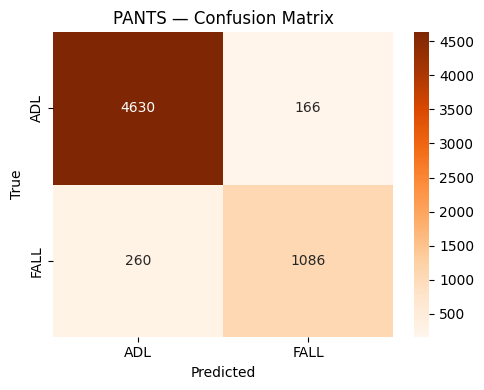

In [6]:
y_test = test_df['label']
y_pred = predictor.predict(test_df)
y_prob = predictor.predict_proba(test_df)[1]

print(f'=== {PLACEMENT} — Test Results ===')
print(classification_report(y_test, y_pred, target_names=['ADL','FALL']))
auc = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC: {auc:.4f}')

lb = predictor.leaderboard(test_df, silent=True)
print('\n=== Leaderboard ===')
print(lb[['model','score_test','score_val']].to_string(index=False))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['ADL','FALL'], yticklabels=['ADL','FALL'])
plt.title(f'{PLACEMENT} — Confusion Matrix')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f'models/{PLACEMENT}_confusion.png', dpi=150)
plt.show()

## 5. Save Results

In [7]:
results = {
    'placement': PLACEMENT, 'dataset': 'FallAllD-Waist (hip proxy)',
    'n_windows': len(feat_df), 'n_features': len(FEATURE_NAMES),
    'test_f1': float(f1_score(y_test, y_pred)),
    'precision': float(precision_score(y_test, y_pred)),
    'recall': float(recall_score(y_test, y_pred)),
    'auc': float(auc),
    'best_model': lb.iloc[0]['model'] if len(lb) > 0 else 'unknown',
}
pd.DataFrame([results]).to_csv(f'models/{PLACEMENT}_results.csv', index=False)
print(f'Saved models/{PLACEMENT}_results.csv')
for k,v in results.items(): print(f'  {k}: {v}')

Saved models/PANTS_results.csv
  placement: PANTS
  dataset: FallAllD-Waist (hip proxy)
  n_windows: 30708
  n_features: 26
  test_f1: 0.836027713625866
  precision: 0.8674121405750799
  recall: 0.8068350668647846
  auc: 0.9706757860376465
  best_model: ExtraTreesGini
